# Social Data and Visualizations 

### importing needed libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import os
import matplotlib.pyplot as plt
import calplot
from pandas.api.types import CategoricalDtype
import seaborn as sns
import plotly.express as px
import folium
import chardet
import geopandas as gpd
from geopandas.tools import geocode
import warnings
from geopy.geocoders import Nominatim
import missingno as msno

### importing Natural Disasters data

In [2]:

Natural_Disasters = pd.read_excel('NaturalDisasters.xlsx')

In [3]:

Natural_Disasters_Subtype = Natural_Disasters[(Natural_Disasters['Disaster Subtype']=='Drought')|(Natural_Disasters['Disaster Subtype']=='Heat wave')]
Natural_Disasters_Subtype_After_1990 =Natural_Disasters_Subtype[Natural_Disasters_Subtype['Year']>1990]
Natural_Disasters_Scope = Natural_Disasters_Subtype_After_1990[["Dis No",'Year','Disaster Subtype','Country', 'ISO', 'Region', 'Continent', 'Total Deaths',
        'No Injured', 'No Affected', 'No Homeless', 'Total Affected',"Total Damages ('000 US$)","Reconstruction Costs ('000 US$)"]]

### managing Nan values off totaly affected.

The logic will be that we will sum 'Total Deaths','No Injured', 'No Affected', 'No Homeless'and in case 'Total Affected' is Nan then we will assign that value


In [4]:
#Annua_freshwater_withdrawal_total

"""
mask = Natural_Disasters_Scope.isnull()


plt.figure(figsize=(15, 20))


# Create a heatmap of missing values
sns.heatmap(mask, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()
"""

"\nmask = Natural_Disasters_Scope.isnull()\n\n\nplt.figure(figsize=(15, 20))\n\n\n# Create a heatmap of missing values\nsns.heatmap(mask, cmap='viridis', cbar=False)\nplt.title('Missing Values Heatmap')\nplt.show()\n"

the lines that do not have total affected values we consider that it is rhe sum of total deaths, no affected, no of injured and no of homeless.

In [5]:
Natural_Temp = Natural_Disasters_Scope
Temp1 = Natural_Disasters_Scope

# creates a new line that has the sum of 'Total Deaths','No Injured', 'No Homeless' if total affected is null
Temp1['New Affected'] = Temp1.loc[ Temp1['Total Affected'].isnull(),[ 'Total Deaths','No Injured', 'No Homeless']].sum(axis=1)
# convert zero values to nan
Temp1.loc[Temp1['New Affected'] <= 0, 'New Affected'] = np.nan
# fill total affected nan values with new affected values
Temp1.loc[Temp1['Total Affected'].isnull(), 'Total Affected'] = Temp1.loc[Temp1['Total Affected'].isnull(), 'New Affected']


C:\Users\asmun\AppData\Local\Temp\ipykernel_40824\1871077039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Temp1['New Affected'] = Temp1.loc[ Temp1['Total Affected'].isnull(),[ 'Total Deaths','No Injured', 'No Homeless']].sum(axis=1)


remove unecessery rows

In [6]:
Temp1 = Temp1.drop(['New Affected','No Injured','No Homeless',"Total Damages ('000 US$)","Reconstruction Costs ('000 US$)"], axis=1)



In [7]:
Natural_Disasters_Scope = Temp1

grouping data based on county and Year.

count indices

In [8]:

instances = Natural_Disasters_Scope.groupby(['ISO','Year','Disaster Subtype', 'Region', 'Continent'])['Dis No'].count().reset_index()

compute total affected

In [9]:

Total_affected = Natural_Disasters_Scope.groupby(['ISO','Year','Disaster Subtype', 'Region', 'Continent'])['Total Affected'].sum().reset_index()

In [10]:

Total_deaths = Natural_Disasters_Scope.groupby(['ISO','Year','Disaster Subtype', 'Region', 'Continent'])['Total Deaths'].sum().reset_index()

combining the three groupings

In [11]:
Natural_Disasters_Scope =  pd.merge(instances,Total_deaths, on =['ISO','Year','Disaster Subtype', 'Region', 'Continent'])
Natural_Disasters_Scope =  pd.merge(Natural_Disasters_Scope,Total_affected, on =['ISO','Year','Disaster Subtype', 'Region', 'Continent'])

In [12]:
Natural_Disasters_Scope

,ISO,Year,Disaster Subtype,Region,Continent,Dis No,Total Deaths,Total Affected
0,AFG,2000,Drought,Southern Asia,Asia,1,37.0,2580000.0
1,AFG,2006,Drought,Southern Asia,Asia,1,0.0,1900000.0
2,AFG,2008,Drought,Southern Asia,Asia,1,0.0,280000.0
3,AFG,2011,Drought,Southern Asia,Asia,1,0.0,1750000.0
4,AFG,2018,Drought,Southern Asia,Asia,1,0.0,13500000.0
...,...,...,...,...,...,...,...,...
664,ZWE,2007,Drought,Eastern Africa,Africa,1,0.0,2100000.0
665,ZWE,2010,Drought,Eastern Africa,Africa,1,0.0,1667618.0
666,ZWE,2013,Drought,Eastern Africa,Africa,1,0.0,4300000.0
667,ZWE,2017,Drought,Eastern Africa,Africa,1,0.0,6900000.0


In [13]:
filtr = Natural_Disasters_Scope['ISO'].unique()

### importing energy consumption dataset

In [15]:
energy_consumption = pd.read_csv('primary-energy-cons.xls')

In [16]:
energy_consumption = energy_consumption[energy_consumption['Year']>1990 ] 
energy_consumption['ISO']=energy_consumption['Code']
energy_consumption

,Entity,Code,Year,Primary energy consumption (TWh),ISO
11,Afghanistan,AFG,1991,13.902764,AFG
12,Afghanistan,AFG,1992,9.167781,AFG
13,Afghanistan,AFG,1993,9.105348,AFG
14,Afghanistan,AFG,1994,8.815903,AFG
15,Afghanistan,AFG,1995,7.428904,AFG
...,...,...,...,...,...
12146,Zimbabwe,ZWE,2015,54.651080,ZWE
12147,Zimbabwe,ZWE,2016,46.665936,ZWE
12148,Zimbabwe,ZWE,2017,45.936050,ZWE
12149,Zimbabwe,ZWE,2018,47.502068,ZWE


In [17]:
GDP_absolut = pd.read_excel('GDP_absolut.xls')

In [18]:

pd.set_option('display.float_format', lambda x: f'{x:.3f}')

### Importing the rest of the datasets 

In [19]:
def data_clean(name = 'GDP_per_capita'):

    GDP_per_capita_raw = pd.read_excel(name + '.xls')
    GDP_per_capita_raw.drop(['Unnamed: 2','Unnamed: 3',], axis='columns', inplace=True)
    GDP_per_capita_raw.drop([0,1], axis='rows', inplace=True)
    GDP_per_capita_renamed = GDP_per_capita_raw
    GDP_per_capita_renamed.columns = GDP_per_capita_renamed.iloc[0]
    GDP_per_capita_renamed.drop([2], axis='rows', inplace=True)
    GDP_per_capita = GDP_per_capita_renamed.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name=name)
    GDP_per_capita['Year'] = GDP_per_capita['Year'].astype(int)
    final = GDP_per_capita[GDP_per_capita["Year"]>1990]
    return final

In [20]:
GDP_per_capita = data_clean(name = 'GDP_per_capita')
GDP_absolut = data_clean(name = 'GDP_absolut')
GDP_agriculture = data_clean(name = 'GDP_agriculture')
GDP_exports = data_clean(name = 'GDP_exports')
GDP_industry = data_clean(name = 'GDP_industry')
Imports_percent_GDP = data_clean(name = 'Imports_percent_GDP')
Cerial_Yields = data_clean(name = 'Cerial_Yields')
Annua_freshwater_withdrawal_total = data_clean(name = 'Annua_freshwater_withdrawal_total')
Agriculture_irrigated_Land = data_clean(name = 'Agriculture_irrigated_Land')
Agricultural_Land = data_clean(name = 'Agricultural_Land')
Arable_Land_Percentage = data_clean(name = 'Arable_Land_Percentage')
income_1_of_the_highest_fifth = data_clean(name = 'income_1_of_the_highest_20%')
income_2_of_the_second_fifth = data_clean(name = 'income_2_of_the_second_20%')
income_3_of_the_third_fifth = data_clean(name = 'income_3_of_the_third_20%')
income_4_of_the_fourth_fifth = data_clean(name = 'income_4_of_the_fourth_20%')
income_5_of_the_lowest_fifth = data_clean(name = 'income_5_of_the_lowest_20%')
Poverty_headcount_ratio = data_clean(name = 'Poverty_headcount_ratio')
# income_3_of_the_third_20%

Financial_Dataset = pd.merge(GDP_per_capita,Cerial_Yields, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,GDP_absolut, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,GDP_agriculture, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,GDP_exports, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,GDP_industry, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,Imports_percent_GDP, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,Annua_freshwater_withdrawal_total, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,Agriculture_irrigated_Land, on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,Agricultural_Land , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,Arable_Land_Percentage , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,income_1_of_the_highest_fifth , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,income_2_of_the_second_fifth , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,income_3_of_the_third_fifth , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,income_4_of_the_fourth_fifth , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,income_5_of_the_lowest_fifth , on =['Country Name','Country Code','Year'])
Financial_Dataset = pd.merge(Financial_Dataset,Poverty_headcount_ratio , on =['Country Name','Country Code','Year'])



In [21]:
print(Financial_Dataset['Country Code'].unique())

['ABW' 'AFE' 'AFG' 'AFW' 'AGO' 'ALB' 'AND' 'ARB' 'ARE' 'ARG' 'ARM' 'ASM'
 'ATG' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BEN' 'BFA' 'BGD' 'BGR' 'BHR' 'BHS'
 'BIH' 'BLR' 'BLZ' 'BMU' 'BOL' 'BRA' 'BRB' 'BRN' 'BTN' 'BWA' 'CAF' 'CAN'
 'CEB' 'CHE' 'CHI' 'CHL' 'CHN' 'CIV' 'CMR' 'COD' 'COG' 'COL' 'COM' 'CPV'
 'CRI' 'CSS' 'CUB' 'CUW' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DMA' 'DNK' 'DOM'
 'DZA' 'EAP' 'EAR' 'EAS' 'ECA' 'ECS' 'ECU' 'EGY' 'EMU' 'ERI' 'ESP' 'EST'
 'ETH' 'EUU' 'FCS' 'FIN' 'FJI' 'FRA' 'FRO' 'FSM' 'GAB' 'GBR' 'GEO' 'GHA'
 'GIB' 'GIN' 'GMB' 'GNB' 'GNQ' 'GRC' 'GRD' 'GRL' 'GTM' 'GUM' 'GUY' 'HIC'
 'HKG' 'HND' 'HPC' 'HRV' 'HTI' 'HUN' 'IBD' 'IBT' 'IDA' 'IDB' 'IDN' 'IDX'
 'IMN' 'IND' 'INX' 'IRL' 'IRN' 'IRQ' 'ISL' 'ISR' 'ITA' 'JAM' 'JOR' 'JPN'
 'KAZ' 'KEN' 'KGZ' 'KHM' 'KIR' 'KNA' 'KOR' 'KWT' 'LAC' 'LAO' 'LBN' 'LBR'
 'LBY' 'LCA' 'LCN' 'LDC' 'LIC' 'LIE' 'LKA' 'LMC' 'LMY' 'LSO' 'LTE' 'LTU'
 'LUX' 'LVA' 'MAC' 'MAF' 'MAR' 'MCO' 'MDA' 'MDG' 'MDV' 'MEA' 'MEX' 'MHL'
 'MIC' 'MKD' 'MLI' 'MLT' 'MMR' 'MNA' 'MNE' 'MNG' 'M

In [22]:

#Annua_freshwater_withdrawal_total
FD = Financial_Dataset[Financial_Dataset['Country Code']=='AUT']
mask = FD.isnull()

"""
plt.figure(figsize=(15, 20))


# Create a heatmap of missing values
sns.heatmap(mask, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()
"""


"\nplt.figure(figsize=(15, 20))\n\n\n# Create a heatmap of missing values\nsns.heatmap(mask, cmap='viridis', cbar=False)\nplt.title('Missing Values Heatmap')\nplt.show()\n"

In [23]:
Financial_Dataset = Financial_Dataset.loc[Financial_Dataset['Country Code'].isin(filtr)]

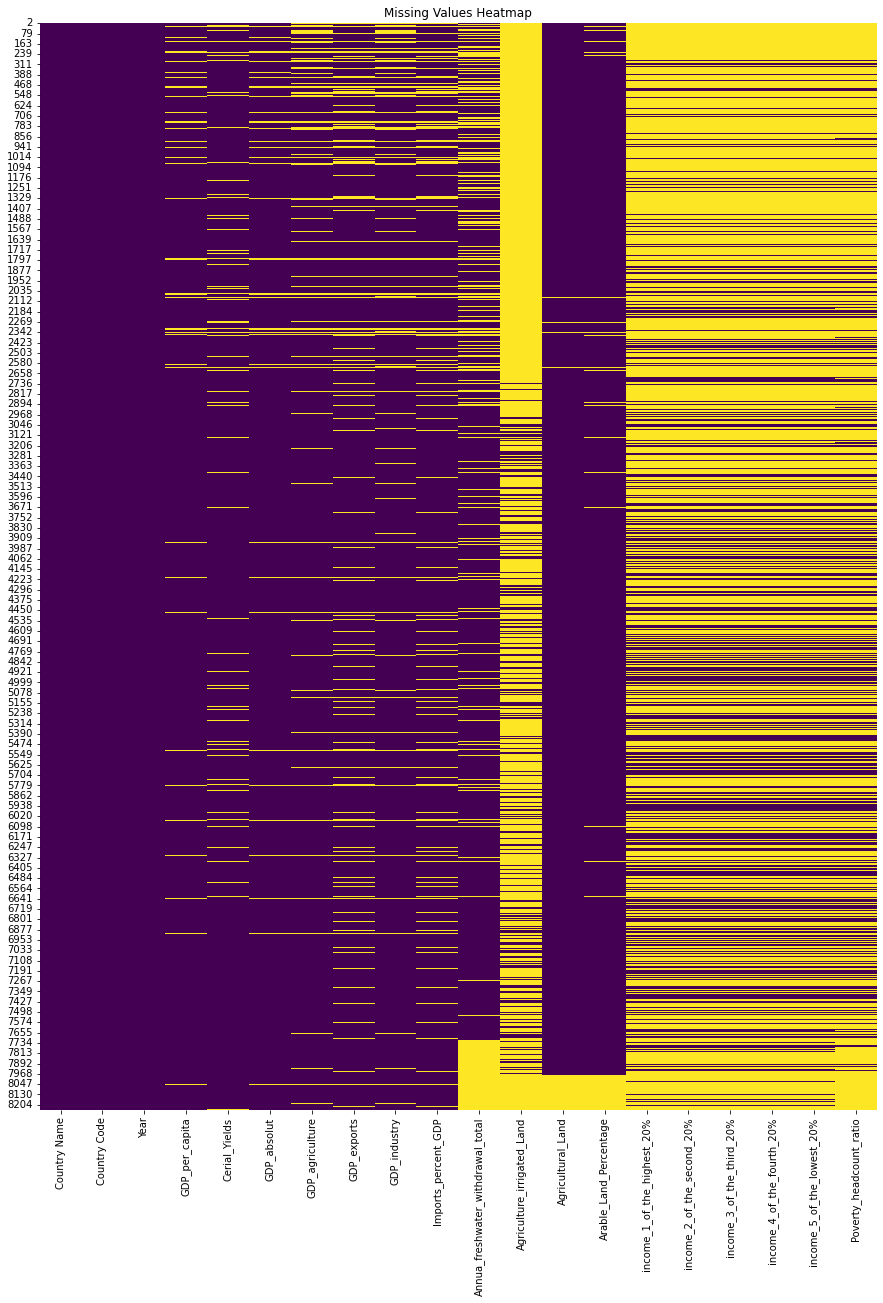

In [24]:
FD = Financial_Dataset
mask = FD.isnull()


plt.figure(figsize=(15, 20))


# Create a heatmap of missing values
sns.heatmap(mask, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()



In [25]:
Financial_Dataset['ISO']= Financial_Dataset['Country Code']

In [26]:
Financial_Dataset.drop(['Country Code'],axis =1)

,Country Name,Year,GDP_per_capita,Cerial_Yields,GDP_absolut,GDP_agriculture,GDP_exports,GDP_industry,Imports_percent_GDP,Annua_freshwater_withdrawal_total,Agriculture_irrigated_Land,Agricultural_Land,Arable_Land_Percentage,income_1_of_the_highest_20%,income_2_of_the_second_20%,income_3_of_the_third_20%,income_4_of_the_fourth_20%,income_5_of_the_lowest_20%,Poverty_headcount_ratio,ISO
2,Afghanistan,1991,NaN,1160.400,NaN,NaN,NaN,NaN,NaN,23.990,NaN,58.308,12.128,NaN,NaN,NaN,NaN,NaN,NaN,AFG
4,Angola,1991,867.123,417.500,10603784541.197,NaN,NaN,NaN,NaN,0.529,NaN,36.547,2.366,NaN,NaN,NaN,NaN,NaN,NaN,AGO
5,Albania,1991,336.587,2071.900,1099559027.778,NaN,7.485,NaN,28.586,1.192,NaN,41.131,21.095,NaN,NaN,NaN,NaN,NaN,NaN,ALB
9,Argentina,1991,5730.724,2433.100,189719984268.485,6.716,7.675,32.723,6.078,28.373,NaN,46.648,9.749,52.500,9.100,13.300,20.300,4.800,1.000,ARG
10,Armenia,1991,572.162,NaN,2069870129.870,NaN,40.745,NaN,60.120,NaN,NaN,41.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8237,Vietnam,2021,3756.489,5947.100,366137590600.699,12.560,93.292,37.476,93.177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VNM
8240,Samoa,2021,3857.318,NaN,843842416.462,9.854,11.687,11.131,49.207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WSM
8243,South Africa,2021,7055.045,5124.700,419015018371.887,2.468,31.194,24.504,25.024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZAF
8244,Zambia,2021,1137.344,2525.000,22147634727.358,3.393,52.078,42.502,33.914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ZMB


In [27]:
Temp_matrix = pd.merge(Financial_Dataset,Natural_Disasters_Scope, on =['ISO','Year'])
Temp_matrix = Temp_matrix.replace(0,np.nan)

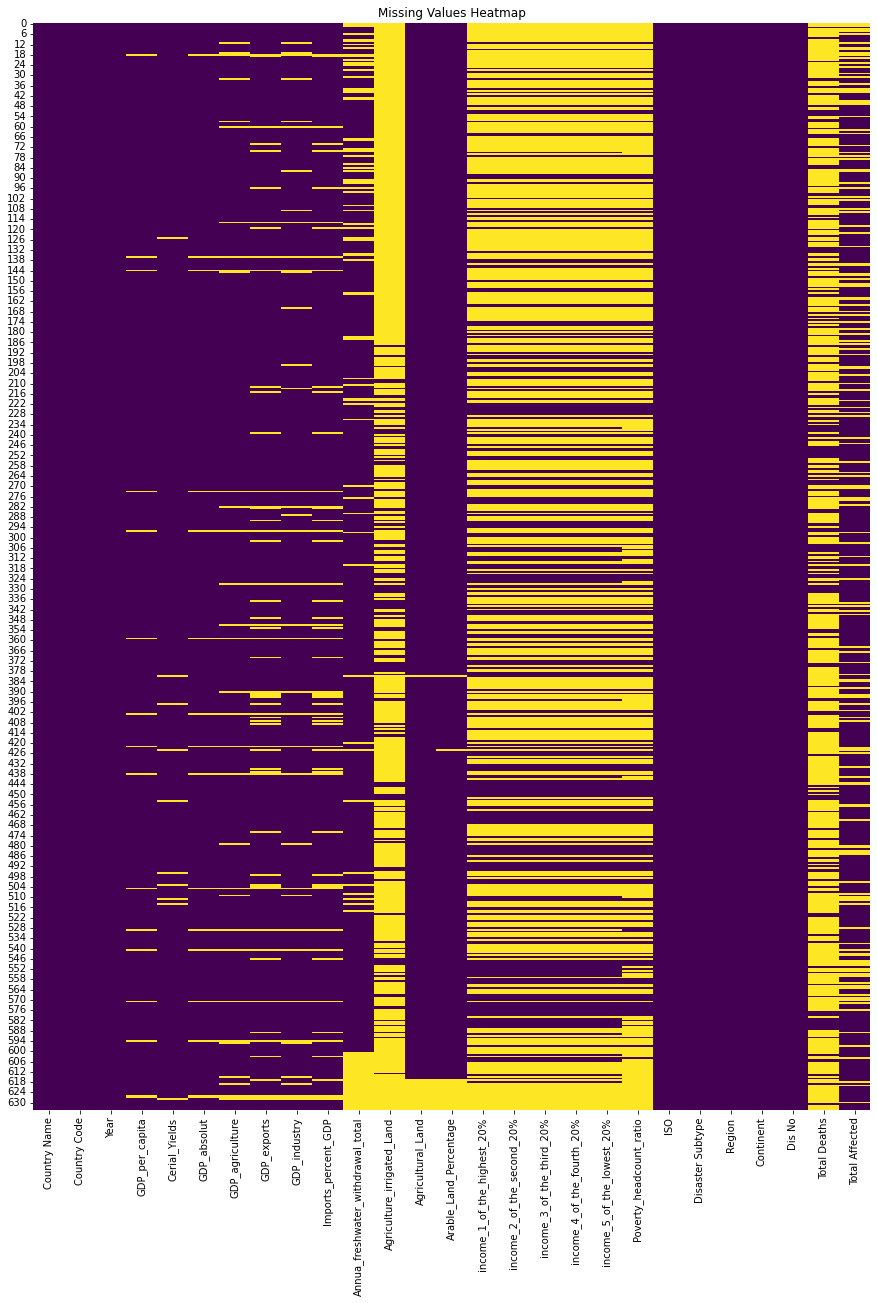

In [28]:
FD = Temp_matrix
mask = FD.isnull()


plt.figure(figsize=(15, 20))


# Create a heatmap of missing values
sns.heatmap(mask, cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()


In [29]:
Death_dataset = Temp_matrix.drop(['Agriculture_irrigated_Land'], axis=1)
Death_dataset = Death_dataset.dropna()
len(Death_dataset)


71

In [30]:
len(Death_dataset)

71

In [31]:
Death_dataset_Ex_Poverty = Temp_matrix.drop(['Agriculture_irrigated_Land','Poverty_headcount_ratio'], axis=1)
Death_dataset_Ex_Poverty = Death_dataset_Ex_Poverty.dropna()

In [32]:
len(Death_dataset_Ex_Poverty)

82

In [33]:
Affected_dataset = Temp_matrix.drop(["Total Deaths",'Agriculture_irrigated_Land','Poverty_headcount_ratio'], axis=1)


In [34]:
len(Affected_dataset)

635

In [35]:
Instances = Temp_matrix.drop(["Total Affected","Total Deaths",'Agriculture_irrigated_Land','Poverty_headcount_ratio'], axis=1)
Instances = Instances.dropna()
len(Instances)

217

## Analysis on Affected dataset

normalize total affected

In [36]:
Affected_dataset['Population'] = Affected_dataset['GDP_absolut']/Affected_dataset['GDP_per_capita']

In [37]:
Affected_dataset['Total Affected normalized'] = Affected_dataset['Total Affected']/Affected_dataset['Population']

In [38]:
Affected_dataset.loc[Affected_dataset['Region']=='Southern Asia','Region'] ='Asia'
Affected_dataset.loc[Affected_dataset['Region']=='Western Africa','Region'] ='Africa'
Affected_dataset.loc[Affected_dataset['Region']=='Eastern Africa','Region'] ='Africa'
Affected_dataset.loc[Affected_dataset['Region']=='Northern Africa','Region'] ='Africa'
Affected_dataset.loc[Affected_dataset['Region']=='Southern Europe','Region'] ='Europe'
Affected_dataset.loc[Affected_dataset['Region']=='South-Eastern Asia','Region'] ='Asia'
Affected_dataset.loc[Affected_dataset['Region']=='South America','Region'] ='South America'
Affected_dataset.loc[Affected_dataset['Region']=='Southern America','Region'] ='South America'
Affected_dataset.loc[Affected_dataset['Region']=='Northern America','Region'] ='Northern America'
Affected_dataset.loc[Affected_dataset['Region']=='Eastern Asia','Region'] ='Asia'
Affected_dataset.loc[Affected_dataset['Region']=='Western Asia','Region'] ='Asia'
Affected_dataset.loc[Affected_dataset['Region']=='Eastern Europe','Region'] ='Europe'
Affected_dataset.loc[Affected_dataset['Region']=='Central Asia','Region'] ='Asia'
Affected_dataset.loc[Affected_dataset['Region']=='Central America','Region'] ='South America'
Affected_dataset.loc[Affected_dataset['Region']=='Western Europe','Region'] ='Europe'
Affected_dataset.loc[Affected_dataset['Region']=='Northern Europe','Region'] ='Europe'
Affected_dataset.loc[Affected_dataset['Region']=='Southern Africa','Region'] ='Africa'

In [39]:
Affected_dataset['Region'].unique()

array(['Australia and New Zealand', 'South America', 'Asia', 'Europe',
       'Africa', 'Northern America', 'Caribbean', 'Middle Africa',
       'Melanesia', 'Micronesia', 'Polynesia'], dtype=object)

In [40]:
colours = {'Asia' : 'green', 'Africa':'blue', 'Northern America': 'red', 'South America':'purple', 'Europe':'yellow','Australia and New Zealand':'orange'}
clrs = ['green','blue', 'red', 'purple', 'yellow','orange']

In [41]:

Affected_dataset_messy = Affected_dataset
Affected_dataset = Affected_dataset.dropna()

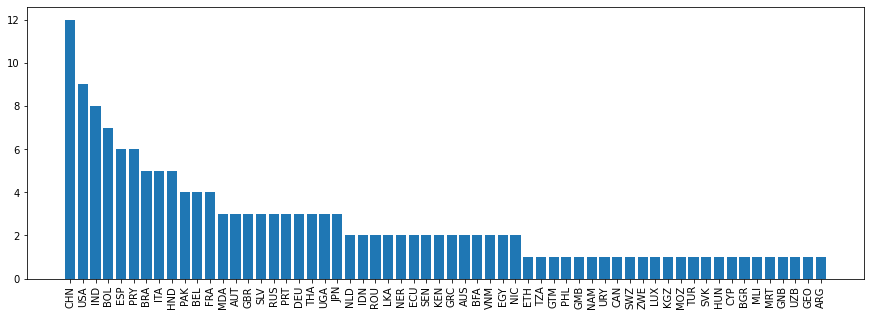

In [42]:
Countries = Affected_dataset['ISO'].value_counts()
plt.figure(figsize=(15,5))

plt.bar(Countries.index,Countries.values)
plt.xticks( rotation=90)

plt.show()

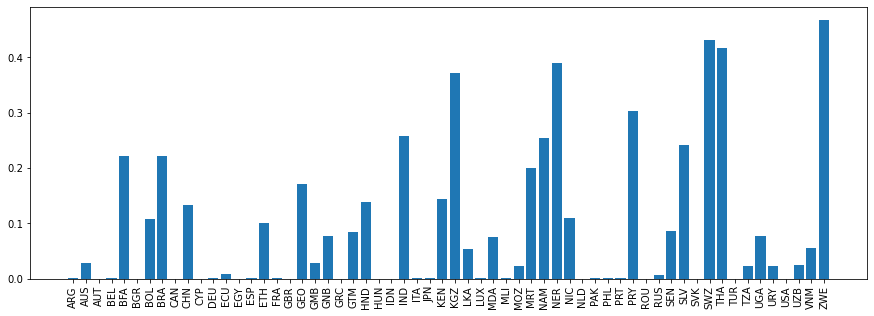

In [43]:
Countries = Affected_dataset.groupby('ISO')['Total Affected normalized'].sum()
plt.figure(figsize=(15,5))

plt.bar(Countries.index,Countries.values)
plt.xticks( rotation=90)

plt.show()

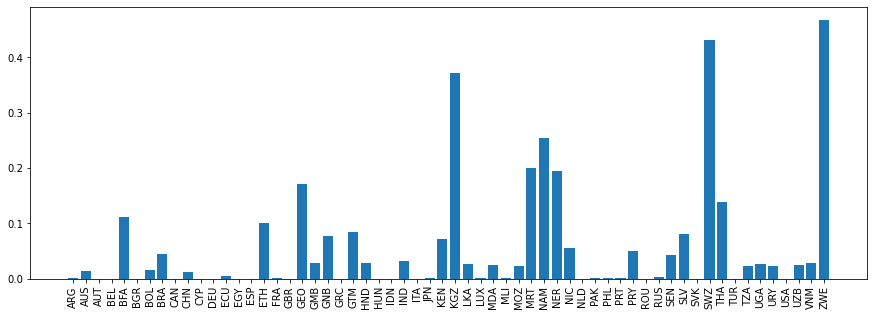

In [44]:
Countries = Affected_dataset.groupby('ISO')['Total Affected normalized'].mean()
plt.figure(figsize=(15,5))

plt.bar(Countries.index,Countries.values)
plt.xticks( rotation=90)

plt.show()

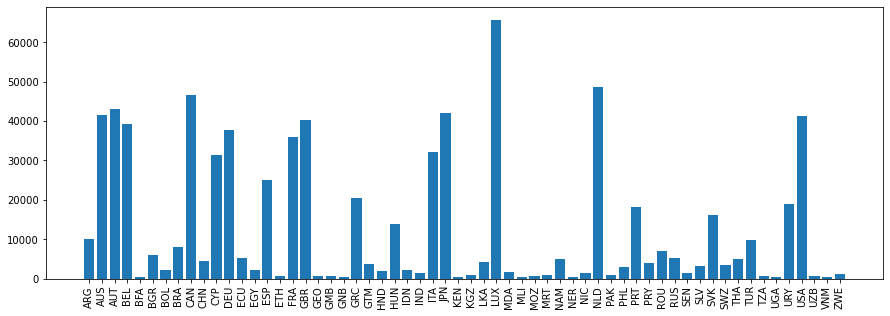

In [45]:
Countries = Affected_dataset.groupby('ISO')['GDP_per_capita'].mean()
plt.figure(figsize=(15,5))

plt.bar(Countries.index,Countries.values)
plt.xticks( rotation=90)

plt.show()

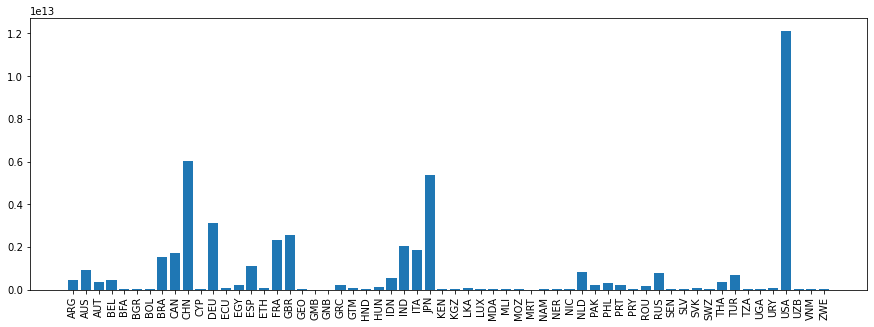

In [46]:
Countries = Affected_dataset.groupby('ISO')['GDP_absolut'].mean()
plt.figure(figsize=(15,5))

plt.bar(Countries.index,Countries.values)
plt.xticks( rotation=90)

plt.show()

Now the the data seem more close. The three higher countries have each only one row in our dataset so we could not getna good enough averaging.

# GO ON FROM HERE

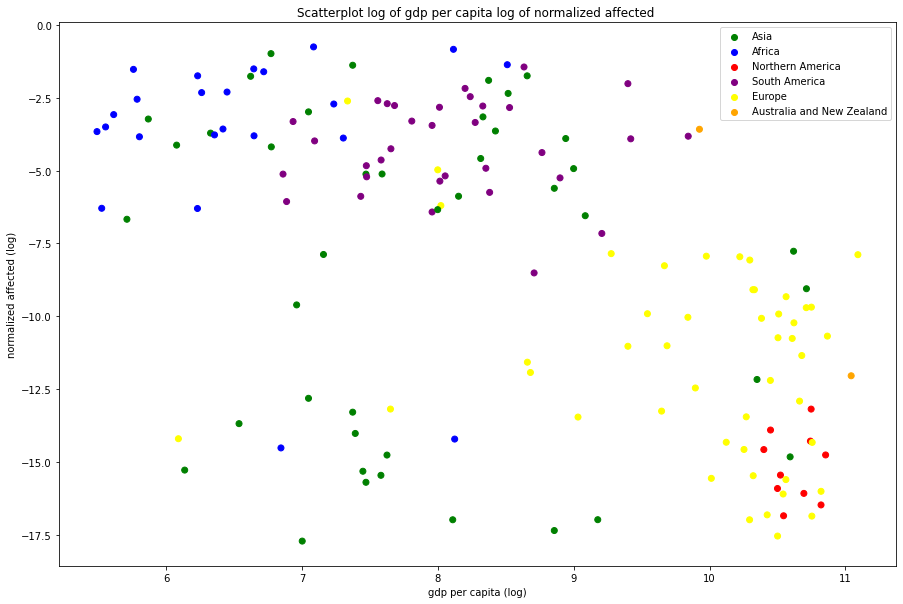

In [47]:

plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset ['GDP_per_capita'] ),np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot log of gdp per capita log of normalized affected ')
plt.xlabel('gdp per capita (log)')
plt.ylabel('normalized affected (log)')

plt.show()


In [48]:
melted = pd.melt(Affected_dataset, id_vars=["Country Name", "Region",'Year','Total Affected normalized'], value_vars=["GDP_per_capita", "GDP_agriculture"], var_name="Indicator", value_name="value")


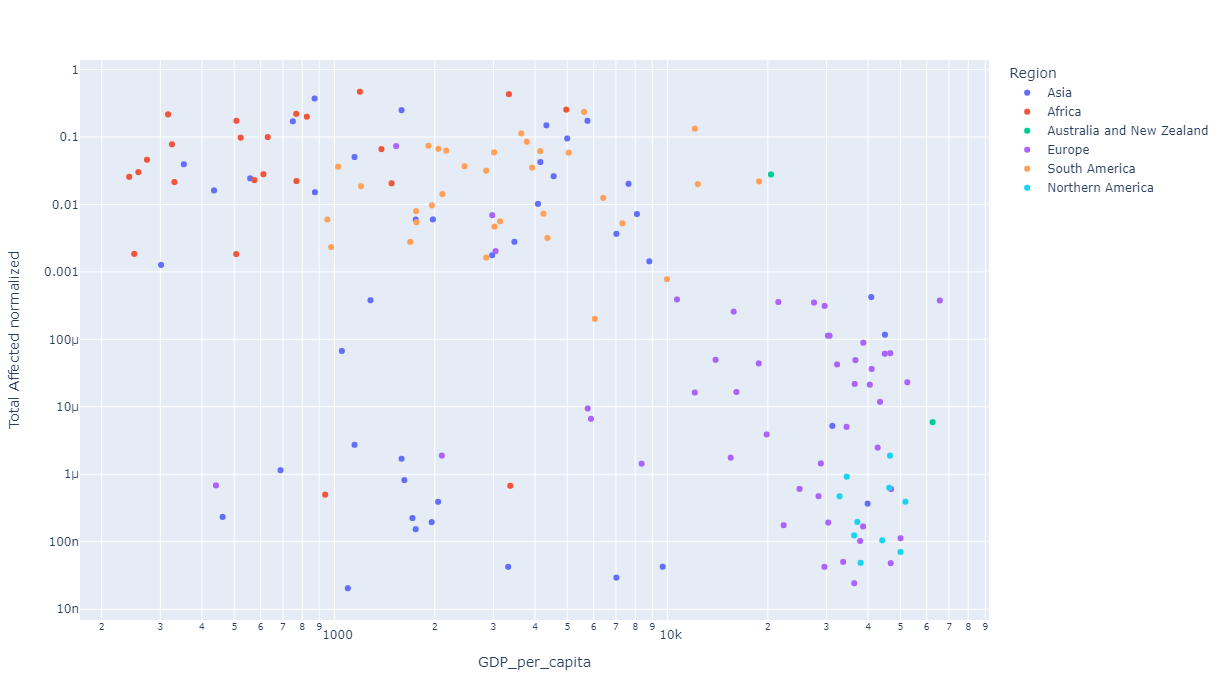

In [51]:
df = px.data.gapminder()
fig = px.scatter(Affected_dataset, x='GDP_per_capita', y='Total Affected normalized', 
            color="Region", hover_name="Country Name",hover_data= ['Year'],
           log_x=True, log_y=True)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_layout(width=900, height=700)
fig.write_html("scatter_gdpc_v2.html")
fig.show()


In [50]:
"""
df = px.data.gapminder()
fig = px.scatter(melted,  x='GDP_per_capita', y='Total Affected normalized', 
            color="Region", hover_name="Country Name",hover_data= ['Year'],
           log_x=True, log_y=True)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_layout(width=900, height=700)
fig.write_html("scatter_gdpc.html")
fig.show()
"""
fig = px.scatter(Affected_dataset, x='GDP_per_capita', y='Total Affected normalized', 
            color="Region", hover_name="Country Name",hover_data= ['Year'],
           log_x=True, log_y=True)

# create a dropdown menu with options corresponding to the column names in the dataframe
dropdown_options = [{'label': col, 'value': col} for col in Affected_dataset.columns]
dropdown = dcc.Dropdown(options=dropdown_options, value='x1')

# define a callback function that updates the x-axis of the scatter plot when the dropdown menu option is changed
def update_figure(selected_column):
    fig.update_xaxes(title=selected_column)
    fig.data[0].x = df[selected_column]

# create a layout that includes the scatter plot and the dropdown menu
layout = html.Div([
    dropdown,
    dcc.Graph(figure=fig, id='scatter-plot')
])

# bind the dropdown menu to the callback function
dropdown.callback(Output('scatter-plot', 'figure'), [Input('dropdown', 'value')])(update_figure)

# get the HTML code for the layout
html_code = pio.to_html(layout, full_html=False)



NameError: name 'dcc' is not defined

In [57]:
Affected_dataset.columns

Index(['Country Name', 'Country Code', 'Year', 'GDP_per_capita',
       'Cerial_Yields', 'GDP_absolut', 'GDP_agriculture', 'GDP_exports',
       'GDP_industry', 'Imports_percent_GDP',
       'Annua_freshwater_withdrawal_total', 'Agricultural_Land',
       'Arable_Land_Percentage', 'income_1_of_the_highest_20%',
       'income_2_of_the_second_20%', 'income_3_of_the_third_20%',
       'income_4_of_the_fourth_20%', 'income_5_of_the_lowest_20%', 'ISO',
       'Disaster Subtype', 'Region', 'Continent', 'Dis No', 'Total Affected',
       'Population', 'Total Affected normalized'],
      dtype='object')

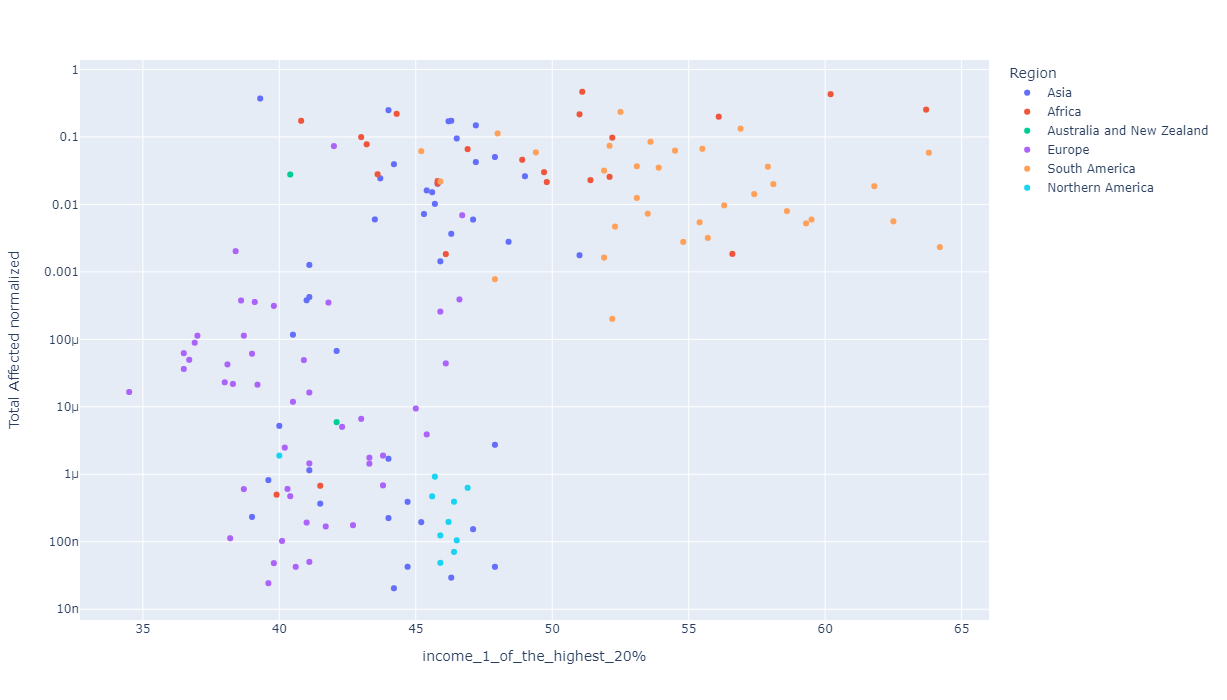

In [58]:
df = px.data.gapminder()
fig = px.scatter(Affected_dataset, x='income_1_of_the_highest_20%'
                 , y='Total Affected normalized', 
            color="Region", hover_name="Country Name",hover_data= ['Year'],
           log_x=False, log_y=True)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_layout(width=900, height=700)
fig.write_html("scatter_gdpc.html")
fig.show()

fig.write_html("income_1_of_the_second_20%.html")

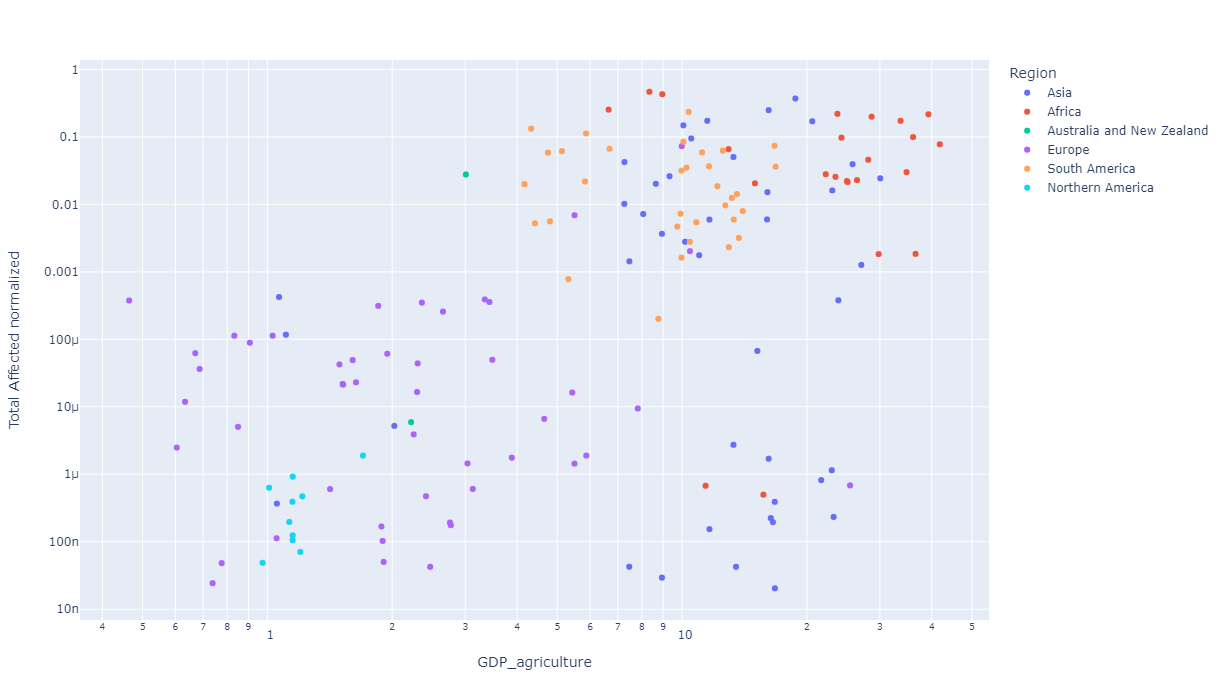

In [64]:
df = px.data.gapminder()
fig = px.scatter(Affected_dataset, x='GDP_agriculture'
                 , y='Total Affected normalized', 
            color="Region", hover_name="Country Name",hover_data= ['Year'],
           log_x=True, log_y=True)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_layout(width=900, height=700)
fig.write_html("scatter_gdpc.html")
fig.show()

fig.write_html("GDP_agriculture.html")

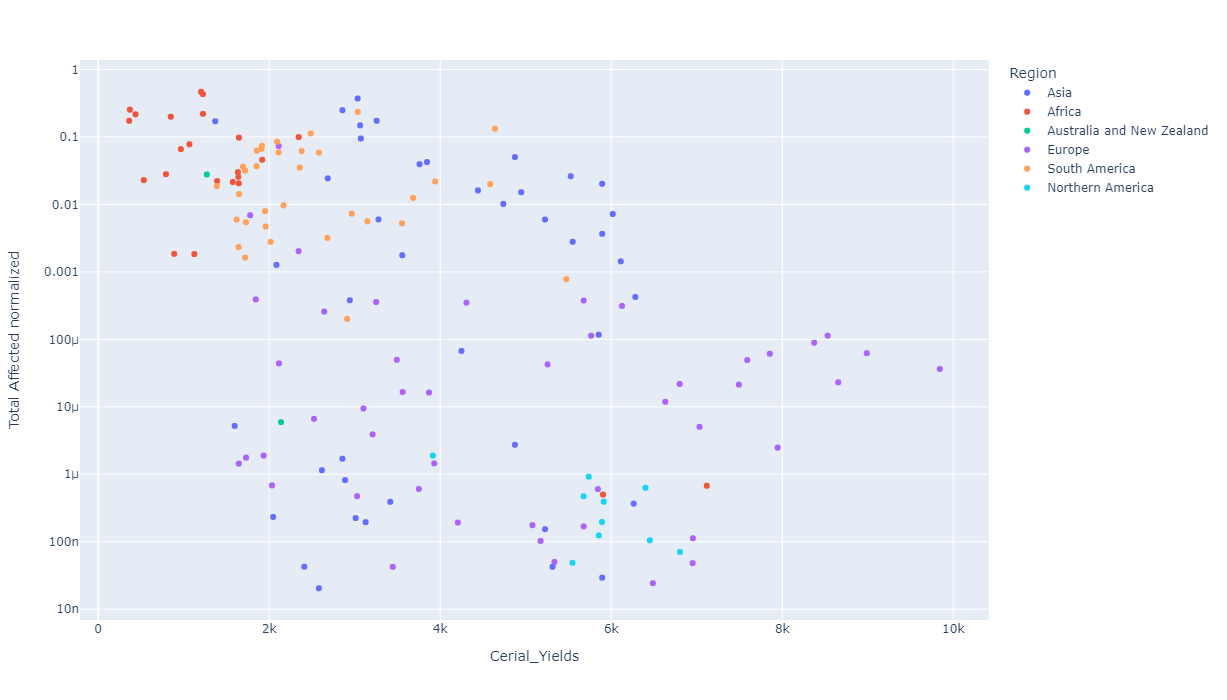

In [66]:
df = px.data.gapminder()
fig = px.scatter(Affected_dataset, x='Cerial_Yields'
                 , y='Total Affected normalized', 
            color="Region", hover_name="Country Name",hover_data= ['Year'],
           log_x=False, log_y=True)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_layout(width=900, height=700)
fig.write_html("scatter_gdpc.html")
fig.show()

fig.write_html("Cerial_Yields.html")

In [62]:
Affected_dataset.columns

Index(['Country Name', 'Country Code', 'Year', 'GDP_per_capita',
       'Cerial_Yields', 'GDP_absolut', 'GDP_agriculture', 'GDP_exports',
       'GDP_industry', 'Imports_percent_GDP',
       'Annua_freshwater_withdrawal_total', 'Agricultural_Land',
       'Arable_Land_Percentage', 'income_1_of_the_highest_20%',
       'income_2_of_the_second_20%', 'income_3_of_the_third_20%',
       'income_4_of_the_fourth_20%', 'income_5_of_the_lowest_20%', 'ISO',
       'Disaster Subtype', 'Region', 'Continent', 'Dis No', 'Total Affected',
       'Population', 'Total Affected normalized'],
      dtype='object')

It seems that there is a negative correlation between normalized affected and gdp per capita. Also, it seems that there can be formed some clusters.

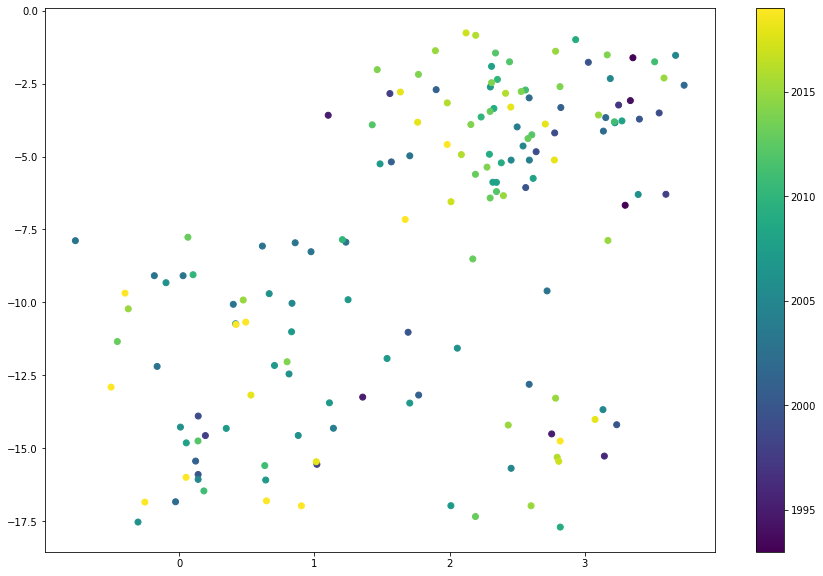

In [59]:

plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'GDP_agriculture'] ),np.log(Affected_dataset ['Total Affected normalized']),c = Affected_dataset['Year'],cmap ='viridis')
plt.colorbar()
plt.show()


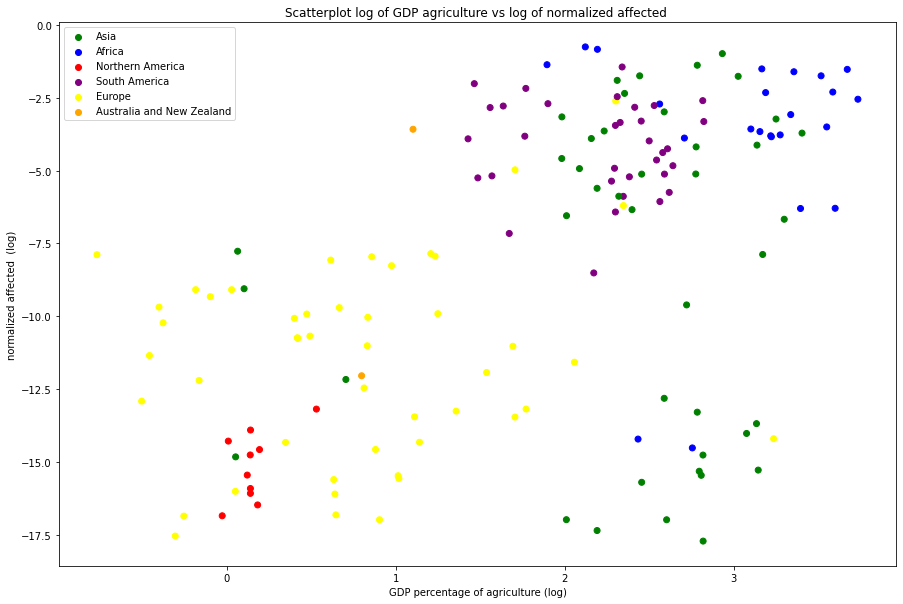

In [60]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'GDP_agriculture'] ),np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot log of GDP agriculture vs log of normalized affected ')
plt.xlabel('GDP percentage of agriculture (log)')
plt.ylabel('normalized affected  (log)')

plt.show()

It is clear that these is a positive corelation betwee the number of poeple that are affected from a drought and the percentage of gdp which id expected. Also the clustering is again visible.

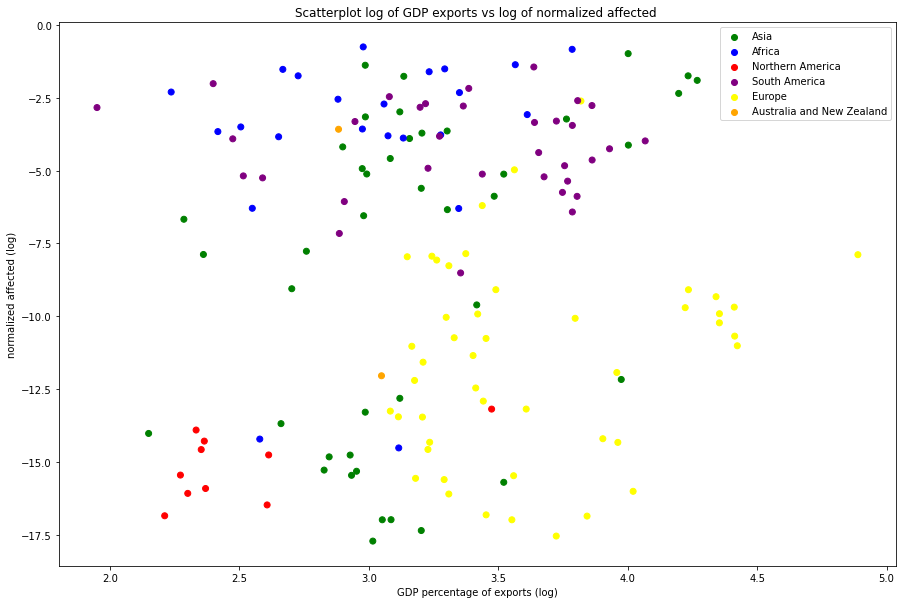

In [61]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'GDP_exports'] ),np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot log of GDP exports vs log of normalized affected ')
plt.xlabel('GDP percentage of exports (log)')
plt.ylabel('normalized affected (log)')

plt.show()

It is clear that these is a positive corelation betwee the number of poeple that are affected from a drought and the percentage of gdp which id expected. Also the clustering is again visible.

In [ ]:
"""
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'GDP_industry'] ),np.log(Affected_dataset ['Total Affected normalized']),c = Affected_dataset['Year'],cmap ='viridis')
plt.colorbar()
plt.show()
"""

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'GDP_industry'] ),np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot log of GDP industry vs log of normalized affected ')
plt.xlabel('GDP percentage of industry (log)')
plt.ylabel('normalized affected (log)')

plt.show()

Also a correlation exists but is not so clear as before. also again the clusters are visible.

In [ ]:
"""
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'Imports_percent_GDP'] ),np.log(Affected_dataset ['Total Affected normalized']),c = Affected_dataset['Year'],cmap ='viridis')
plt.colorbar()
plt.show()
"""

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'Imports_percent_GDP'] ),np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot log of GDP Imports vs log of normalized affected ')
plt.xlabel('GDP percentage of Imports (log)')
plt.ylabel('normalized affected (log)')

plt.show()

In [ ]:
"""
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset ['Total Affected normalized']),Affected_dataset [ 'Cerial_Yields'] ,c = Affected_dataset['Year'],cmap ='viridis')
plt.colorbar()
plt.show()
"""

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'Cerial_Yields'] ,np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot Cerial Yields vs log of normalized affected ')
plt.xlabel('Cerial Yields')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:
"""
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'Annua_freshwater_withdrawal_total'] ),np.log(Affected_dataset ['Total Affected normalized']),c = Affected_dataset['Year'],cmap ='viridis')
plt.colorbar()
plt.show()
"""

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(Affected_dataset [ 'Annua_freshwater_withdrawal_total'] ),np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot Annua freshwater withdrawal total vs log of normalized affected ')
plt.xlabel('Annua freshwater withdrawal total')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:
"""
plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'Agricultural_Land'] ,np.log(Affected_dataset ['Total Affected normalized']),c = Affected_dataset['Year'],cmap ='viridis')
plt.colorbar()
plt.show()
"""

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'Agricultural_Land'] ,np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)
plt.title('Scatterplot Agricultural Land vs log of normalized affected ')
plt.xlabel('Agricultural Land')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'Arable_Land_Percentage'] ,np.log(Affected_dataset ['Total Affected normalized']),c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)

plt.title('Scatterplot Arable Land Percentage vs log of normalized affected ')
plt.xlabel('Arable Land Percentage')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'income_1_of_the_highest_20%'],np.log(Affected_dataset ['Total Affected normalized']) ,c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)

plt.title('Scatterplot income of the reachest 20% of the population vs log of normalized affected ')
plt.xlabel('income of the reachest 20% of the population')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:

plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'income_2_of_the_second_20%'],np.log(Affected_dataset ['Total Affected normalized']) ,c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)

plt.title('Scatterplot income of the second richest 20% of the population vs log of normalized affected ')
plt.xlabel('income of the second richest 20% of the population')
plt.ylabel('normalized affected (log)')
plt.show()

I seems to exist a symmetry between this and the previous diagram. We could argue that this has to do with the fact that the difference detween the richest 20% of the population and the rest of the population is how inequality is defined. And there are many results showing that inequality is a negative factor during natural disasters. 

In [ ]:


plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'income_3_of_the_third_20%'],np.log(Affected_dataset ['Total Affected normalized']) ,c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)

plt.title('Scatterplot income of the third richest 20% of the population vs log of normalized affected ')
plt.xlabel('income of the third richest 20% of the population')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:



plt.figure(figsize=(15,10))
plt.scatter(Affected_dataset [ 'income_4_of_the_fourth_20%'],np.log(Affected_dataset ['Total Affected normalized']) ,c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)

plt.title('Scatterplot income of the fourth richest 20% of the population vs log of normalized affected ')
plt.xlabel('income of the fourth richest 20% of the population')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:
Financial_Dataset = pd.merge(Affected_dataset,energy_consumption , on =['ISO','Year'])

In [ ]:
Financial_Dataset.columns

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(np.log(Financial_Dataset [ 'Primary energy consumption (TWh)']),np.log(Financial_Dataset ['Total Affected normalized']) ,c =[colours[c] for c in Affected_dataset['Region']],label=Affected_dataset['Region'])

handles = []
for category, color in colours.items():
    handles.append(plt.scatter([], [], c=color, label=category))
plt.legend(handles=handles)

plt.title('Scatterplot Primary energy consumption (TWh) vs log of normalized affected ')
plt.xlabel('Primary energy consumption (TWh) of the population')
plt.ylabel('normalized affected (log)')
plt.show()

In [ ]:

Financial_Dataset = pd.merge(Affected_dataset_messy,energy_consumption , on =['ISO','Year'])

In [ ]:
Financial_Dataset = Financial_Dataset.drop(['Country Code','Entity','Code'],axis=1)


In [ ]:
data = pd.read_csv('Affected_dataset.csv')

In [ ]:
data['Cluster'] = data['Cluster'].astype('str')

In [ ]:
df = px.data.gapminder()
fig = px.scatter(data, x='GDP_per_capita', y='Total Affected normalized', 
            color="Cluster", hover_name="Country Name",hover_data= ['Year'],
           log_x=True, log_y=True)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
fig.update_layout(width=900, height=700)
fig.write_html("scatter_gdpc.html")
fig.show()

In [ ]:
Affected_dataset[['ISO','Region']]